## Kode

### Preprocessing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
import os
from tqdm.keras import TqdmCallback
from tqdm.notebook import tqdm
from statsmodels.tsa.stattools import adfuller, ccf, acf
from tensorflow.keras.callbacks import ModelCheckpoint
import random

In [ ]:
sales = pd.read_excel('/content/drive/MyDrive/Data Uji/sales_oppo.xlsx', parse_dates=['tgl'])
sales.head()

,tgl,A15/A15S,A16/A16S,A52/A92,A53/A33 2020,A54,A74/A95,A92S,RENO 3 PRO,RENO 3/A91/F15,...,RENO 4 PRO,RENO 4F/A93,RENO 4F/F17P/A9,RENO 5,RENO 5F,RENO 5F/A94,RENO 6,RENO 6 4G,RENO 6 PRO,sales
0,2021-01-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-01-02,5,0,5,0,0,0,0,0,5,...,0,3,0,0,0,0,0,0,0,18
2,2021-01-03,0,0,0,1,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,4
3,2021-01-04,0,0,2,1,0,0,0,0,0,...,2,9,0,0,0,0,0,0,0,14
4,2021-01-05,0,0,6,24,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,37


### Sentimen

In [ ]:
sentimen = pd.read_excel('/content/drive/MyDrive/Data Uji/sentimen_oppo.xlsx', parse_dates=['publishedAt'])
sentimen.head()

,publishedAt,0,1,2
0,2021-01-01,4,0,3
1,2021-01-02,4,2,4
2,2021-01-03,1,1,6
3,2021-01-04,9,2,6
4,2021-01-05,6,0,7


In [ ]:
df = pd.DataFrame()
df[['tgl', 'sales']] = sales[['tgl', 'sales']].copy()
df[['negatif', 'netral', 'positif']] = sentimen[[0, 1, 2]].copy()
df.head()

,tgl,sales,negatif,netral,positif
0,2021-01-01,0,4,0,3
1,2021-01-02,18,4,2,4
2,2021-01-03,4,1,1,6
3,2021-01-04,14,9,2,6
4,2021-01-05,37,6,0,7


In [ ]:
df['rating'] = (df['positif']) / (df['positif'] + df['negatif'])
df.head()

,tgl,sales,negatif,netral,positif,rating
0,2021-01-01,0,4,0,3,0.428571
1,2021-01-02,18,4,2,4,0.500000
2,2021-01-03,4,1,1,6,0.857143
3,2021-01-04,14,9,2,6,0.400000
4,2021-01-05,37,6,0,7,0.538462


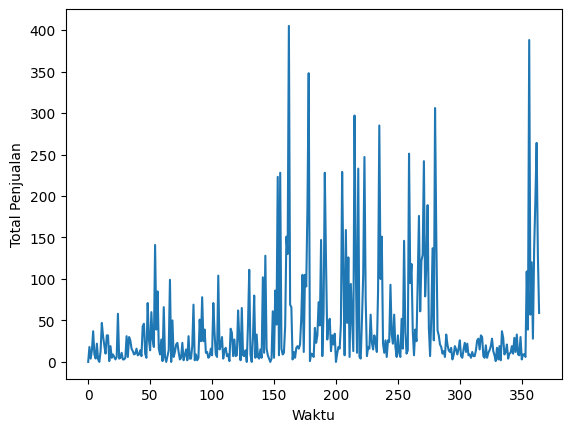

In [ ]:
plt.figure()
plt.plot(df['sales'])
plt.xlabel('Waktu')
plt.ylabel('Total Penjualan')
plt.show()

### Outlier

In [ ]:
Q1 = df['sales'].quantile(0.25)
Q3 = df['sales'].quantile(0.75)
IQR = Q3 - Q1

batas_atas = Q3 + 1.5 * IQR
batas_bawah = Q1 - 1.5 * IQR

batas = int(len(df[:-28]) * 0.8)
mean_non_outlier = df[(df['sales'] >= batas_bawah) & (df['sales'] <= batas_atas)]['sales'].iloc[:batas].mean()
df['sales'] = df['sales'].apply(lambda x: mean_non_outlier if x < batas_bawah or x > batas_atas else x)
df.head()

,tgl,sales,negatif,netral,positif,rating
0,2021-01-01,0.0,4,0,3,0.428571
1,2021-01-02,18.0,4,2,4,0.500000
2,2021-01-03,4.0,1,1,6,0.857143
3,2021-01-04,14.0,9,2,6,0.400000
4,2021-01-05,37.0,6,0,7,0.538462


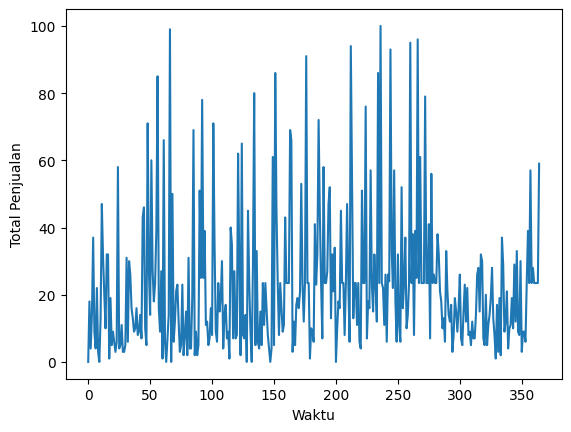

In [ ]:
plt.figure()
plt.plot(df['sales'])
plt.xlabel('Waktu')
plt.ylabel('Total Penjualan')
plt.show()

### Stationarity Test Augmented Dicky-Fuller (ADF)

In [ ]:
# # Uji ADF
adf_result = adfuller(df['rating'])
# adf_result = adfuller(df['sales'])

print("p-value :", adf_result[1])

# p-value < 0.05 menolak h0 berarti data stationer
# p-value > 0.05 menerima h0 berarti data non-stationer
if adf_result[1] < 0.05:
  print(f'P-value < 0.05, berarti Menolak H0 berarti data stationer')
else:
  print(f'P-value > 0.05, berarti Gagal menolak H0 berarti data non-stationer')

p-value : 1.0909827637077998e-18
P-value < 0.05, berarti Menolak H0 berarti data stationer


### Differencing

In [ ]:
# df['rating'] = df['rating'].diff()
# df['sales'] = df['sales'].diff()
# df = df.dropna()

### CCF

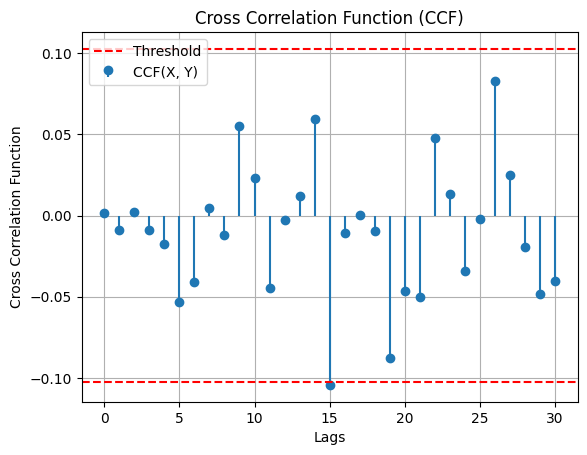

In [ ]:
X = df['rating']
Y = df['sales']

# CCF
lag_max = 30
ccf_values = ccf(X, Y)[:lag_max + 1]
z_threshold = 1.96 / np.sqrt(len(X)) # Nilai threshold dengan confidence 95%

plt.figure()
plt.stem(range(len(ccf_values)), ccf_values, label='CCF(X, Y)', basefmt=" ")
plt.axhline(y=z_threshold, color='r', linestyle='--', label='Threshold')
plt.axhline(y=-z_threshold, color='r', linestyle='--')
plt.title('Cross Correlation Function (CCF)' )
plt.xlabel('Lags')
plt.ylabel('Cross Correlation Function')
plt.legend()
plt.grid(True)
plt.show()

### Preprocessing Sentimen

In [ ]:
df['rating_lag'] = df['rating'].shift(26)
df = df.drop(columns=['negatif', 'netral', 'positif', 'rating'])
df = df.dropna()
df.head()

,tgl,sales,rating_lag
26,2021-01-27,5.0,0.428571
27,2021-01-28,11.0,0.500000
28,2021-01-29,3.0,0.857143
29,2021-01-30,3.0,0.400000
30,2021-01-31,5.0,0.538462


### Datetime

In [ ]:
def ektraksi_datetime(df):
    df['tgl'] = pd.to_datetime(df['tgl'])
    df['dayOfTheWeek'] = df['tgl'].dt.weekday
    df['dayOfTheMonth'] = df['tgl'].dt.day
    return df

def add_holiday(df):
  df['tgl'] = pd.to_datetime(df['tgl'])

  holiday_list = [
      "2021-01-01", "2021-02-12", "2021-03-11", "2021-03-12", "2021-03-14",
      "2021-04-02", "2021-05-01", "2021-05-12", "2021-05-13", "2021-05-14",
      "2021-05-17", "2021-05-18", "2021-05-19", "2021-05-26", "2021-06-01",
      "2021-07-20", "2021-08-10", "2021-08-17", "2021-10-19", "2021-12-24",
      "2021-12-25", "2021-12-27"
      ]

  holiday_dates = set(pd.to_datetime(holiday_list).date)
  df["is_holiday"] = df["tgl"].dt.date.isin(holiday_dates).astype(int)

  return df

def add_weekend(df):
  df['tgl'] = pd.to_datetime(df['tgl'])
  df['is_weekend'] = df['tgl'].dt.weekday.isin([5,6]).astype(int)
  return df

def add_payday(df):
  df['tgl'] = pd.to_datetime(df['tgl'])
  df['is_payday'] = df['tgl'].dt.day.isin([1,25]).astype(int)
  return df

In [ ]:
df = ektraksi_datetime(df)
df = add_holiday(df)
df = add_weekend(df)
df = add_payday(df)
df.head()

,tgl,sales,rating_lag,dayOfTheWeek,dayOfTheMonth,is_holiday,is_weekend,is_payday
26,2021-01-27,5.0,0.428571,2,27,0,0,0
27,2021-01-28,11.0,0.500000,3,28,0,0,0
28,2021-01-29,3.0,0.857143,4,29,0,0,0
29,2021-01-30,3.0,0.400000,5,30,0,1,0
30,2021-01-31,5.0,0.538462,6,31,0,1,0


### Train Test Split

In [ ]:
# Input dan Output
input_features = [
                  'sales',
                  'rating_lag',
                  # 'is_holiday', 'is_weekend', 'is_payday',
                  # 'dayOfTheWeek', 'dayOfTheMonth',
                  ]
output_features = ['sales']
X = df[input_features].values
y = df[output_features].values

In [ ]:
X_test = X[-28:]
y_test = y[-28:]
train_X = X[:-28]
train_y = y[:-28]
split = int(len(train_X) * 0.8)
X_train, X_val, y_train, y_val = train_X[:split], train_X[split:], train_y[:split], train_y[split:]
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((248, 2), (63, 2), (28, 2), (248, 1), (63, 1), (28, 1))

In [ ]:
X_scaler = MinMaxScaler(feature_range=(0,1))
X_train_scaled = X_scaler.fit_transform(X_train)
X_val_scaled = X_scaler.transform(X_val)
X_test_scaled = X_scaler.transform(X_test)

y_scaler = MinMaxScaler(feature_range=(0,1))
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)
y_test_scaled = y_scaler.transform(y_test)

In [ ]:
timesteps = 14
n_features_input = len(input_features)
n_features_output = len(output_features)

def create_sequences(X, y, timesteps):
  X_seq, y_seq = [], []

  for i in range(len(X) - timesteps):
    X_seq.append(X[i : i + timesteps])
    y_seq.append(y[i + timesteps])

  return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, timesteps)
X_train_seq.shape, X_val_seq.shape, X_test_seq.shape, y_train_seq.shape, y_val_seq.shape, y_test_seq.shape

((234, 14, 2), (49, 14, 2), (14, 14, 2), (234, 1), (49, 1), (14, 1))

### Grid Search

In [ ]:
batch_size_options = [16, 32]
learning_rate_options = [0.001, 0.0001]
num_layer_options = [1, 2, 3]
hasil = []

folder = '/content/drive/MyDrive/uji_ccf_2/rm_rating_sk_1_lag_6'

# Penyimpanan
if not os.path.exists(folder):
    os.makedirs(folder)

# Grid Search
for batch_size in batch_size_options:
  for learning_rate in learning_rate_options:
    for num_layer in num_layer_options:

      print(f"Parameter : batch_size={batch_size}, lr={learning_rate}, layers={num_layer}")

      model = Sequential()

      # Input
      model.add(Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])))

      # Layer LSTM
      if num_layer > 1:
        for i in range(num_layer - 1):
          model.add(LSTM(units=64, activation='relu', return_sequences=True))
          model.add(Dropout(0.2))

      # Layer Penutup
      model.add(LSTM(units=64, activation='relu', return_sequences=False))
      model.add(Dropout(0.2))

      # Output Layer
      model.add(Dense(units=1))

      # Compile model
      model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mae')

      # Checkpoint
      model_name = f'model_bs_{batch_size}_lr_{learning_rate}_layers_{num_layer}.keras'
      model_path = os.path.join(folder, model_name)
      checkpoint = ModelCheckpoint(
          filepath=model_path,
          save_best_only=True,
          mode='min'
          )

      # Fitting model
      hist = model.fit(X_train_seq,
                       y_train_seq,
                       epochs=100,
                       batch_size=batch_size,
                       validation_data=(X_val_seq, y_val_seq),
                       verbose=0,
                       callbacks=[checkpoint, TqdmCallback(verbose=0)])

      # Validasi
      model = load_model(model_path)
      y_pred = model.predict(X_val_seq, verbose=0)
      y_pred_model = y_scaler.inverse_transform(y_pred)
      y_pred_asli = y_scaler.inverse_transform(y_val_seq)

      mae_val = np.mean(np.abs(y_pred_asli - y_pred_model))
      rmse_val = np.sqrt(np.mean((y_pred_asli - y_pred_model)**2))
      smape_val = np.mean(2 * np.abs(y_pred_asli - y_pred_model) / (np.abs(y_pred_asli) + np.abs(y_pred_model))) * 100
      mase_val = np.mean(np.abs(y_pred_asli - y_pred_model)[1:] / np.mean(np.abs(y_pred_asli[1:] - y_pred_asli[:-1])))
      # print(f'MAE hasil validasi : {mae_val:.2f}')
      # print(f'RMSE hasil validasi : {rmse_val:.2f}')
      print(f'sMAPE hasil testing : {smape_val:.2f}')
      print(f'MASE hasil testing : {mase_val:.2f}')

      # Prediksi
      prediksi = []
      last_sequence = X_val_seq[-1]

      for i in tqdm(range(len(y_test_scaled))):
        ypred = model.predict(last_sequence.reshape(1, X_train_seq.shape[1], X_train_seq.shape[2]), verbose=0)
        prediksi.append(ypred[0,0])
        new_features = X_test_scaled[i, :].copy()
        new_features[0] = ypred.flatten()[0]
        last_sequence = np.vstack([last_sequence[1:], new_features])

      prediksi = np.array(prediksi, dtype=np.float32).reshape(-1, 1)
      data_prediksi = y_scaler.inverse_transform(prediksi)
      data_asli = y_scaler.inverse_transform(y_test_scaled)

      mae_test = np.mean(np.abs(data_asli - data_prediksi))
      rmse_test = np.sqrt(np.mean((data_asli - data_prediksi)**2))
      smape_test = np.mean(2 * np.abs(data_asli - data_prediksi) / (np.abs(data_asli) + np.abs(data_prediksi))) * 100
      mase_test = np.mean(np.abs(data_asli - data_prediksi)[1:] / np.mean(np.abs(data_asli[1:] - data_asli[:-1])))

      # print(f'MAE hasil testing : {mae_test:.2f}')
      # print(f'RMSE hasil testing : {rmse_test:.2f}')
      print(f'sMAPE hasil testing : {smape_test:.2f}')
      print(f'MASE hasil testing : {mase_test:.2f}')

      params = f"batch_size={batch_size}, lr={learning_rate}, layers={num_layer}"
      hasil_dict = {
          'parameter' : params,
          'batch_size': batch_size,
          'learning_rate': learning_rate,
          'num_layer': num_layer,
          'mae_val': mae_val,
          'rmse_val': rmse_val,
          'smape_val': smape_val,
          'mase_val': mase_val,
          'mae_test': mae_test,
          'rmse_test': rmse_test,
          'smape_test': smape_test,
          'mase_test': mase_test,
          'loss' : hist.history['loss'],
          'val_loss' : hist.history['val_loss']
          }
      hasil.append(hasil_dict)

      print("-" * 50)

df_hasil = pd.DataFrame(hasil)
df_hasil.to_excel('grid_search.xlsx', index=False)
print("Hasil grid search telah disimpan ke grid_search_results.xlsx")

Parameter : batch_size=16, lr=0.001, layers=1


0epoch [00:00, ?epoch/s]

sMAPE hasil testing : 36.07
MASE hasil testing : 0.94


  0%|          | 0/28 [00:00<?, ?it/s]

sMAPE hasil testing : 46.10
MASE hasil testing : 0.70
--------------------------------------------------
Parameter : batch_size=16, lr=0.001, layers=2


0epoch [00:00, ?epoch/s]

sMAPE hasil testing : 36.17
MASE hasil testing : 0.94


  0%|          | 0/28 [00:00<?, ?it/s]

sMAPE hasil testing : 47.22
MASE hasil testing : 0.72
--------------------------------------------------
Parameter : batch_size=16, lr=0.001, layers=3


0epoch [00:00, ?epoch/s]

sMAPE hasil testing : 35.91
MASE hasil testing : 0.94


  0%|          | 0/28 [00:00<?, ?it/s]

sMAPE hasil testing : 47.39
MASE hasil testing : 0.73
--------------------------------------------------
Parameter : batch_size=16, lr=0.0001, layers=1


0epoch [00:00, ?epoch/s]

sMAPE hasil testing : 36.67
MASE hasil testing : 0.95


  0%|          | 0/28 [00:00<?, ?it/s]

sMAPE hasil testing : 47.45
MASE hasil testing : 0.72
--------------------------------------------------
Parameter : batch_size=16, lr=0.0001, layers=2


0epoch [00:00, ?epoch/s]

sMAPE hasil testing : 36.80
MASE hasil testing : 0.95


  0%|          | 0/28 [00:00<?, ?it/s]

sMAPE hasil testing : 46.70
MASE hasil testing : 0.70
--------------------------------------------------
Parameter : batch_size=16, lr=0.0001, layers=3


0epoch [00:00, ?epoch/s]

sMAPE hasil testing : 36.23
MASE hasil testing : 0.94


  0%|          | 0/28 [00:00<?, ?it/s]

sMAPE hasil testing : 46.49
MASE hasil testing : 0.70
--------------------------------------------------
Parameter : batch_size=32, lr=0.001, layers=1


0epoch [00:00, ?epoch/s]

sMAPE hasil testing : 35.42
MASE hasil testing : 0.92


  0%|          | 0/28 [00:00<?, ?it/s]

sMAPE hasil testing : 49.13
MASE hasil testing : 0.74
--------------------------------------------------
Parameter : batch_size=32, lr=0.001, layers=2


0epoch [00:00, ?epoch/s]

sMAPE hasil testing : 36.42
MASE hasil testing : 0.95


  0%|          | 0/28 [00:00<?, ?it/s]

sMAPE hasil testing : 49.23
MASE hasil testing : 0.78
--------------------------------------------------
Parameter : batch_size=32, lr=0.001, layers=3


0epoch [00:00, ?epoch/s]

sMAPE hasil testing : 36.08
MASE hasil testing : 0.94


  0%|          | 0/28 [00:00<?, ?it/s]

sMAPE hasil testing : 46.24
MASE hasil testing : 0.70
--------------------------------------------------
Parameter : batch_size=32, lr=0.0001, layers=1


0epoch [00:00, ?epoch/s]

sMAPE hasil testing : 36.82
MASE hasil testing : 0.95


  0%|          | 0/28 [00:00<?, ?it/s]

sMAPE hasil testing : 47.38
MASE hasil testing : 0.71
--------------------------------------------------
Parameter : batch_size=32, lr=0.0001, layers=2


0epoch [00:00, ?epoch/s]

sMAPE hasil testing : 36.93
MASE hasil testing : 0.95


  0%|          | 0/28 [00:00<?, ?it/s]

sMAPE hasil testing : 46.72
MASE hasil testing : 0.71
--------------------------------------------------
Parameter : batch_size=32, lr=0.0001, layers=3


0epoch [00:00, ?epoch/s]

sMAPE hasil testing : 36.10
MASE hasil testing : 0.94


  0%|          | 0/28 [00:00<?, ?it/s]

sMAPE hasil testing : 46.51
MASE hasil testing : 0.71
--------------------------------------------------
Hasil grid search telah disimpan ke grid_search_results.xlsx


### Prediksi

In [ ]:
model = load_model('/content/drive/MyDrive/uji_ccf_2/op_rating_sk_3_lag_26/model_bs_16_lr_0.001_layers_3.keras')

prediksi = model.predict(X_val_seq)
hasil_prediksi = y_scaler.inverse_transform(prediksi)
y_pred_asli = y_scaler.inverse_transform(y_val_seq)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step


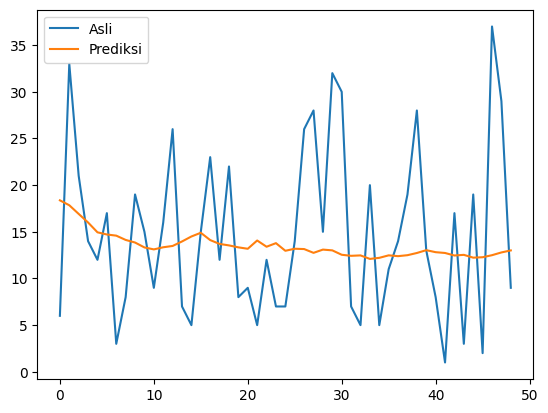

In [ ]:
plt.figure()
plt.plot(y_pred_asli, label='Asli')
plt.plot(hasil_prediksi, label='Prediksi')
plt.legend()
plt.show()

In [ ]:
mae_val = np.mean(np.abs(y_pred_asli - hasil_prediksi))
rmse_val = np.sqrt(np.mean((y_pred_asli - hasil_prediksi)**2))
smape_val = np.mean(2 * np.abs(y_pred_asli - hasil_prediksi) / (np.abs(y_pred_asli) + np.abs(hasil_prediksi))) * 100
mase_val = np.mean(np.abs(y_pred_asli - hasil_prediksi)[1:] / np.mean(np.abs(y_pred_asli[1:] - y_pred_asli[:-1])))

print(f'MAE hasil testing : {mae_val:.2f}')
print(f'RMSE hasil testing : {rmse_val:.2f}')
print(f'sMAPE hasil testing : {smape_val:.2f}')
print(f'MASE hasil testing : {mae_val:.2f}')

MAE hasil testing : 7.42
RMSE hasil testing : 9.21
sMAPE hasil testing : 54.83
MASE hasil testing : 7.42


In [ ]:
prediksi = []
last_sequence = X_val_seq[-1]

for i in range(len(y_test_scaled)):
  ypred = model.predict(last_sequence.reshape(1, X_train_seq.shape[1], X_train_seq.shape[2]))
  prediksi.append(ypred[0,0])
  new_features = X_test_scaled[i, :].copy()
  new_features[0] = ypred.flatten()[0]
  last_sequence = np.vstack([last_sequence[1:], new_features])
prediksi = np.array(prediksi, dtype=np.float32).reshape(-1, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

In [ ]:
data_prediksi = y_scaler.inverse_transform(prediksi)
data_asli = y_scaler.inverse_transform(y_test_scaled)

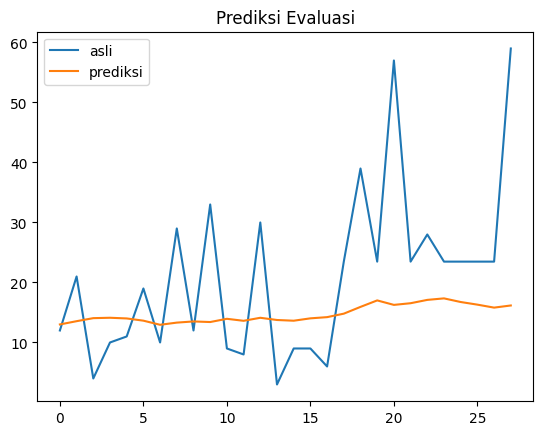

In [ ]:
plt.figure()
plt.plot(data_asli, label='asli')
plt.plot(data_prediksi, label='prediksi')
plt.title('Prediksi Evaluasi')
plt.legend()
plt.show()

In [ ]:
mae_test = np.mean(np.abs(data_asli - data_prediksi))
rmse_test = np.sqrt(np.mean((data_asli - data_prediksi)**2))
smape_test = np.mean(2 * np.abs(data_asli - data_prediksi) / (np.abs(data_asli) + np.abs(data_prediksi))) * 100
mase_test = np.mean(np.abs(data_asli - data_prediksi)[1:] / np.mean(np.abs(data_asli[1:] - data_asli[:-1])))

print(f'MAE hasil testing : {mae_test:.2f}')
print(f'RMSE hasil testing : {rmse_test:.2f}')
print(f'sMAPE hasil testing : {smape_test:.2f}')
print(f'MASE hasil testing : {mase_test:.2f}')

MAE hasil testing : 10.47
RMSE hasil testing : 14.51
sMAPE hasil testing : 54.25
MASE hasil testing : 0.83


### Train-Test

In [ ]:
# Train
y_pred_train = model.predict(X_train_seq)
y_pred_train_model = y_scaler.inverse_transform(y_pred_train)
y_pred_train_asli = y_scaler.inverse_transform(y_train_seq)

# Validation
y_pred = model.predict(X_val_seq)
y_pred_model = y_scaler.inverse_transform(y_pred)
y_pred_asli = y_scaler.inverse_transform(y_val_seq)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


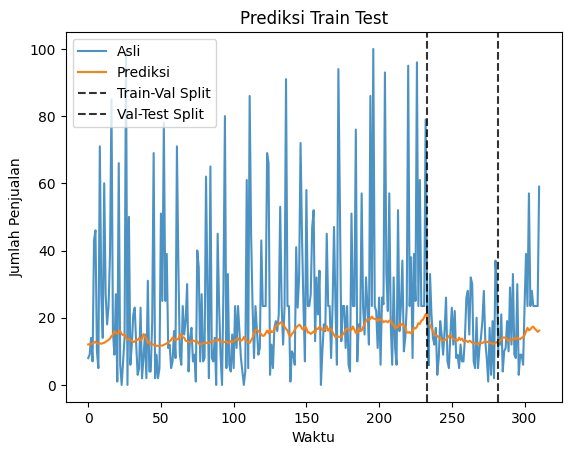

In [ ]:
plt.figure()

# Train
plt.plot(y_pred_train_asli, color='#1f77b4', label='Asli', alpha=0.8)
plt.plot(y_pred_train_model, color='#ff7f0e', label='Prediksi')

# Test
plt.plot(range(len(y_train_seq), len(y_train_seq) + len(y_val_seq)), y_pred_asli, color='#1f77b4', alpha=0.8)
plt.plot(range(len(y_train_seq), len(y_train_seq) + len(y_val_seq)), y_pred_model, color='#ff7f0e')

# Random Line
plt.plot([len(y_pred_train_asli)-1, len(y_pred_train_asli)], [y_pred_train_asli[-1], y_pred_asli[0]], color='#1f77b4')
plt.plot([len(y_pred_train_model)-1, len(y_pred_train_model)], [y_pred_train_model[-1], y_pred_model[0]], linestyle='--', color='#ff7f0e')
plt.axvline(len(y_train_seq) - 1, color='black', linestyle='--', alpha=0.8, label='Train-Val Split')
plt.axvline(len(y_train_seq)+len(y_val_seq) - 1, color='black', linestyle='--', alpha=0.8, label='Val-Test Split')

plt.plot(range(len(y_train_seq)+len(y_val_seq), len(y_train_seq)+len(y_val_seq)+len(y_test)), y_test, color='#1f77b4', alpha=0.8)

plt.plot(range(len(y_train_seq)+len(y_val_seq), len(y_train_seq)+len(y_val_seq)+len(y_test)), data_prediksi, color='#ff7f0e')

plt.title('Prediksi Train Test')
plt.xlabel('Waktu')
plt.ylabel('Jumlah Penjualan')
plt.legend()
plt.show()

## Analisis Error

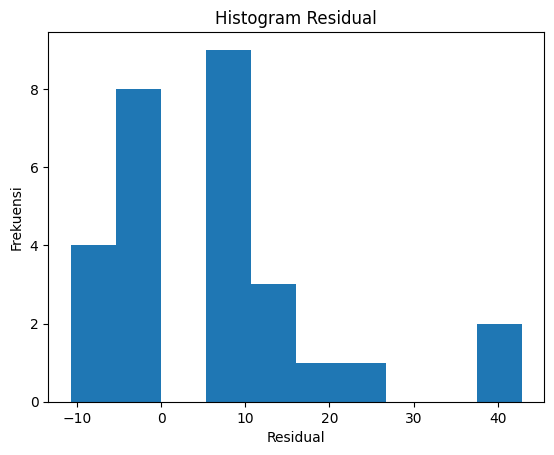

In [ ]:
residuals = data_asli - data_prediksi

plt.figure()
plt.hist(residuals)
plt.title('Histogram Residual')
plt.xlabel('Residual')
plt.ylabel('Frekuensi')
plt.show()

<Figure size 640x480 with 0 Axes>

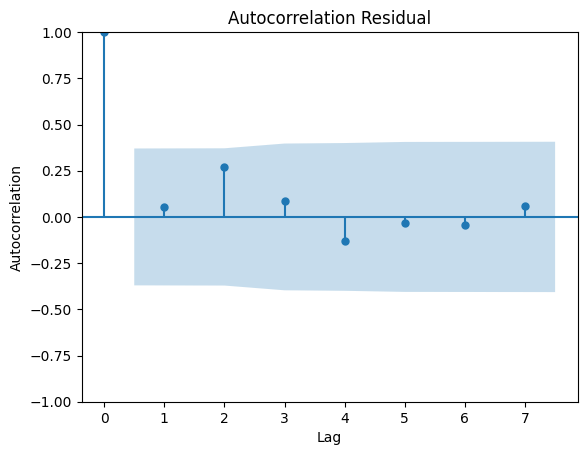

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure()
plot_acf(residuals.flatten(), lags=7, title='Autocorrelation Residual')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

## MC Dropout

In [ ]:
prediksi_mc = []
last_sequence = X_val_seq[-1]

for i in range(len(y_test_scaled)):
  prediksi = []
  for _ in range(50):
    ypred = model(last_sequence.reshape(1, X_train_seq.shape[1], X_train_seq.shape[2]), training=True)
    prediksi.append(ypred.numpy().item())
  prediksi = np.array(prediksi)
  prediksi_mc.append(prediksi)
  # Pembentukan Sequence Baru
  rata_rata_prediksi = np.array(prediksi).mean()
  new_features = X_test_scaled[i, :].copy()
  new_features[0] = rata_rata_prediksi
  last_sequence = np.vstack([last_sequence[1:], new_features])

In [ ]:
prediksi_mc_array = np.array(prediksi_mc)
mean_prediksi = np.mean(prediksi_mc_array, axis=1)
std_prediksi = np.std(prediksi_mc_array, axis=1)
upper_bound = mean_prediksi + 2 * std_prediksi
lower_bound = mean_prediksi - 2 * std_prediksi

In [ ]:
mean_prediksi_unscaled = y_scaler.inverse_transform(mean_prediksi.reshape(-1, 1)).flatten()
upper_bound_unscaled = y_scaler.inverse_transform(upper_bound.reshape(-1, 1)).flatten()
lower_bound_unscaled = y_scaler.inverse_transform(lower_bound.reshape(-1, 1)).flatten()

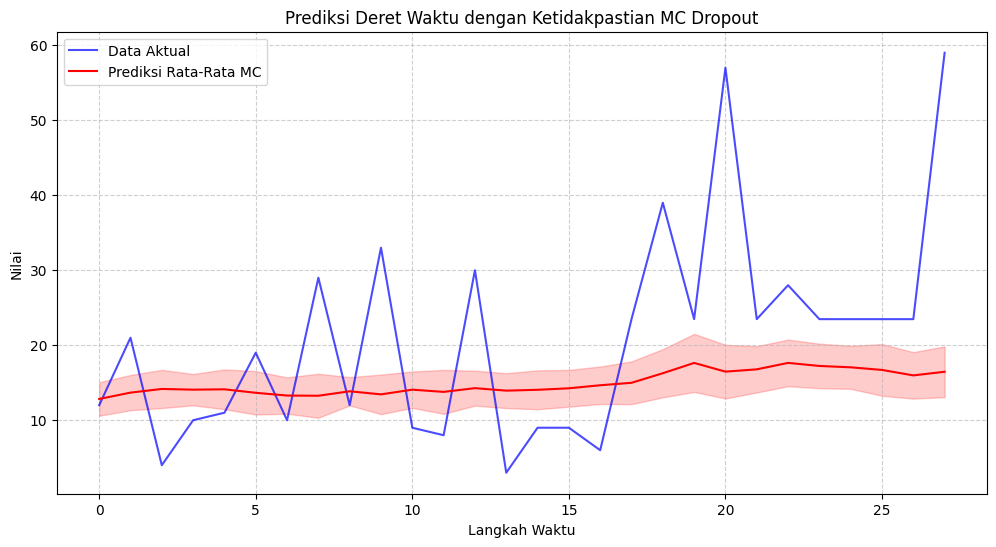

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Data Aktual', color='blue', alpha=0.7)
plt.plot(mean_prediksi_unscaled, label='Prediksi Rata-Rata MC', color='red')
plt.fill_between(
    x=range(len(mean_prediksi_unscaled)),
    y1=lower_bound_unscaled,
    y2=upper_bound_unscaled,
    color='red',
    alpha=0.2,
)
plt.title('Prediksi Deret Waktu dengan Ketidakpastian MC Dropout')
plt.xlabel('Langkah Waktu')
plt.ylabel('Nilai')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Prediksi Train Test

In [ ]:
# Train
y_pred_train = model.predict(X_train_seq)
y_pred_train_model = y_scaler.inverse_transform(y_pred_train)
y_pred_train_asli = y_scaler.inverse_transform(y_train_seq)

# Validation
y_pred = model.predict(X_val_seq)
y_pred_model = y_scaler.inverse_transform(y_pred)
y_pred_asli = y_scaler.inverse_transform(y_val_seq)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


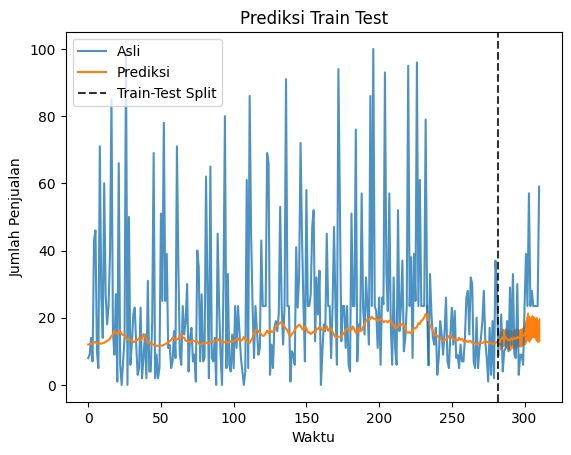

In [ ]:
plt.figure()

# Train
plt.plot(y_pred_train_asli, color='#1f77b4', label='Asli', alpha=0.8)
plt.plot(y_pred_train_model, color='#ff7f0e', label='Prediksi')

# Test
plt.plot(range(len(y_train_seq), len(y_train_seq) + len(y_val_seq)), y_pred_asli, color='#1f77b4', alpha=0.8)
plt.plot(range(len(y_train_seq), len(y_train_seq) + len(y_val_seq)), y_pred_model, color='#ff7f0e')

# Random Line
plt.plot([len(y_pred_train_asli)-1, len(y_pred_train_asli)], [y_pred_train_asli[-1], y_pred_asli[0]], color='#1f77b4')
plt.plot([len(y_pred_train_model)-1, len(y_pred_train_model)], [y_pred_train_model[-1], y_pred_model[0]], linestyle='--', color='#ff7f0e')
# plt.axvline(len(y_train_seq) - 1, color='black', linestyle='--', alpha=0.8, label='Train-Test Split')
plt.axvline(len(y_train_seq)+len(y_val_seq) - 1, color='black', linestyle='--', alpha=0.8, label='Train-Test Split')

plt.plot(range(len(y_train_seq)+len(y_val_seq), len(y_train_seq)+len(y_val_seq)+len(y_test)), y_test, color='#1f77b4', alpha=0.8)

plt.plot(range(len(y_train_seq)+len(y_val_seq), len(y_train_seq)+len(y_val_seq)+len(y_test)), mean_prediksi_unscaled, color='#ff7f0e')

plt.fill_between(
    x=range(len(y_train_seq)+len(y_val_seq), len(y_train_seq)+len(y_val_seq)+len(y_test)),  # Sumbu x (indeks waktu)
    y1=lower_bound_unscaled,              # Batas bawah
    y2=upper_bound_unscaled,              # Batas atas
    color='#ff7f0e',
    # alpha=0.9,
)

plt.title('Prediksi Train Test')
plt.xlabel('Waktu')
plt.ylabel('Jumlah Penjualan')
plt.legend()
plt.show()